In [ ]:
###############################
# File for exploring examples #
###############################
#
# Move complete ideas to new notebooks...
#

In [1]:
import os
from pathlib import Path
#from flame import Machine
import flame
from flame import Machine #Machine() not found without this line
import flame_utils
import numpy as np
import matplotlib.pyplot as plt
import labframePlotFun
%matplotlib inline
#%matplotlib qt #for showing graphs in second window

In [19]:
#Linking to flame/data folder in cwd, and establishing lattice file (.lat)
# latpath definition seems to assume rea-files/ and phantasy-machines/ is in same folder...

# current working dir
#cwd = "/home/devuser/machine-rea"
cwd = os.getcwd()

# locate flame (todo: if not found, search rea-files parent directory, or rea3/data/CrispAnalysis/phantasy-machines)
flamedir = os.path.dirname(os.path.abspath(flame.__file__))
# if found, create link in cwd to flame/data folder
if os.path.isfile(flamedir):
    flamedata = flamedir + '/data'
    os.unlink(cwd + '/data')
    os.symlink(flamedata, cwd + '/data')

# define latfile
#latfile = "ReA3_JENSA.lat"
#latfile_handle = open(cwd + '/' + latfile, 'rb')
latfile = "baseline_gpl_fully_corrected.lat"
latpath = str(Path(cwd).parent) + '/phantasy-machines/ReA/GPL/' + latfile
latfile_handle = open(latpath, 'rb')
latpath

'/projects/rea3/data/CrispAnalysis/phantasy-machines/ReA/GPL/baseline_gpl_fully_corrected.lat'

In [3]:
# create FLAME machine
m = Machine(latfile_handle)

# create BeamState object
bs = flame_utils.BeamState(machine=m)

# create ModelFlame object
fm = flame_utils.ModelFlame()

In [4]:
# setup machine and state
fm.bmstate, fm.machine = bs, m

In [5]:
# setup observers and run flame model
#obs = fm.get_index_by_type(type='bpm')['bpm']
#obs = fm.get_index_by_type(type='marker')['marker']
obs = range(len(fm.machine))
r,s = fm.run(monitor=obs)

In [6]:
# get data of interest from running results
data = fm.collect_data(r, pos=True, x0_env=True, x0_rms=True, y0_env=True, y0_rms=True, ref_IonEk=True)

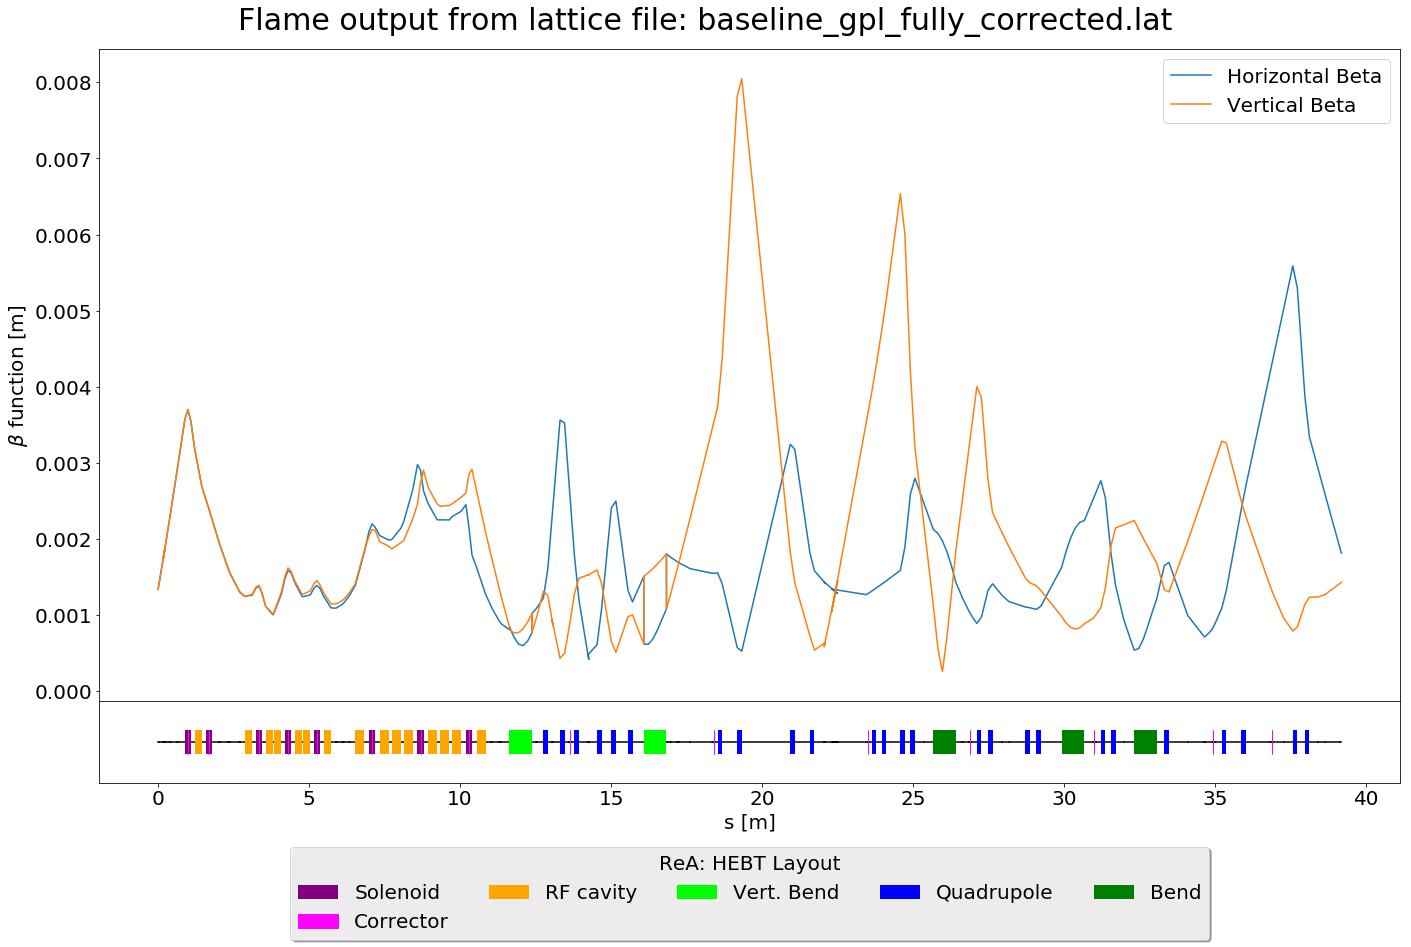

In [7]:
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [20,12]
fig,(ax1,ax2)=plt.subplots(2, 1,gridspec_kw = {'height_ratios':[8,1]}, sharex=True)
fig.suptitle('Flame output from lattice file: ' + latfile, fontsize=30)

ax2,xmin,xmax,ymin,ymax = labframePlotFun.labframePlot(latpath, ax2, 0)
ax2.set_ylim([-1.0,1.0])
plt.setp(ax2, yticks=[])

ax1.plot(data['pos'], data['x0_rms']/1000.0, label='Horizontal Beta')
ax1.plot(data['pos'], data['y0_rms']/1000.0, label='Vertical Beta')
ax2.set_xlabel('s [m]')
ax1.set_ylabel(r'$\beta$ function [m]')
ax1.legend(loc='best')

fig.tight_layout(rect=(0,0,1,0.96))
plt.subplots_adjust(hspace=0.0)
plt.show()

In [8]:
#fm.bmstate.beammatrix_all

In [9]:
m.conf()

OrderedDict([('Eng_Data_Dir', '/etc/flame/cavity_data'),
             ('HdipoleFitMode', 1.0),
             ('IonChargeStates', array([ 0.25])),
             ('IonEk', 500000.0),
             ('IonEs', 931494000.0),
             ('MpoleLevel', 2.0),
             ('NCharge', array([ 1000.])),
             ('P0', array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.])),
             ('S0',
              array([  1.80000000e+00,   3.00000000e-03,   0.00000000e+00,
                       0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
                       0.00000000e+00,   3.00000000e-03,   7.20000000e-06,
                       0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
                       0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
                       0.00000000e+00,   1.80000000e+00,   3.00000000e-03,
                       0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
                       0.00000000e+00,   0.00000000e+00,   3.00000000e-03,
                      

In [10]:
m.find(type='quadrupole') # find element index by element type

[138,
 145,
 152,
 173,
 175,
 177,
 223,
 225,
 227,
 229,
 249,
 251,
 253,
 255,
 272,
 274,
 290,
 292,
 305,
 307,
 318,
 328,
 330,
 347,
 349]

In [11]:
m.find(name='REA_BTS25:Q_D1164') # find element index by element name

[138]

In [12]:
m.conf(138).keys() # Parameter keys of element

odict_keys(['B2', 'Eng_Data_Dir', 'HdipoleFitMode', 'IonChargeStates', 'IonEk', 'IonEs', 'L', 'MpoleLevel', 'NCharge', 'P0', 'S0', 'aper', 'name', 'sim_type', 'type'])

In [13]:
m.conf(138)['B2'] # Quadrupole Strength
#can change with m.reconfigure(138, {'B2': 19.0})

-20.0041

In [14]:
# Run for the selected section
S = m.allocState({}) # allocate the beam state? somehow bs which we defined earlier was not a beam state?
m.propagate(S, 0, 138)
S1 = S.clone() # clone the beam state
m.propagate(S1, 138, -1) # simulate from 138th to last element

[]

In [15]:
####################
# Quadrupole Scan  #
####################

In [16]:
ini = m.conf(138)['B2'] # store the initial quadrupole strength
ini

-20.0041

In [17]:
# run simulation up to target element
SA = m.allocState({})
rA = m.propagate(SA, 0, 138, observe=range(len(m))) # propagate

# scan parameters by using single loop
b2lst = [-5.0, -7.5, -10, -12.5, -15, -17.5, -20]
rlst = []
for b2 in b2lst:
    SB = SA.clone()
    m.reconfigure(138, {'B2':b2})
    rt = m.propagate(SB,138,-1,observe=range(len(m)))
    rlst.append(rt)

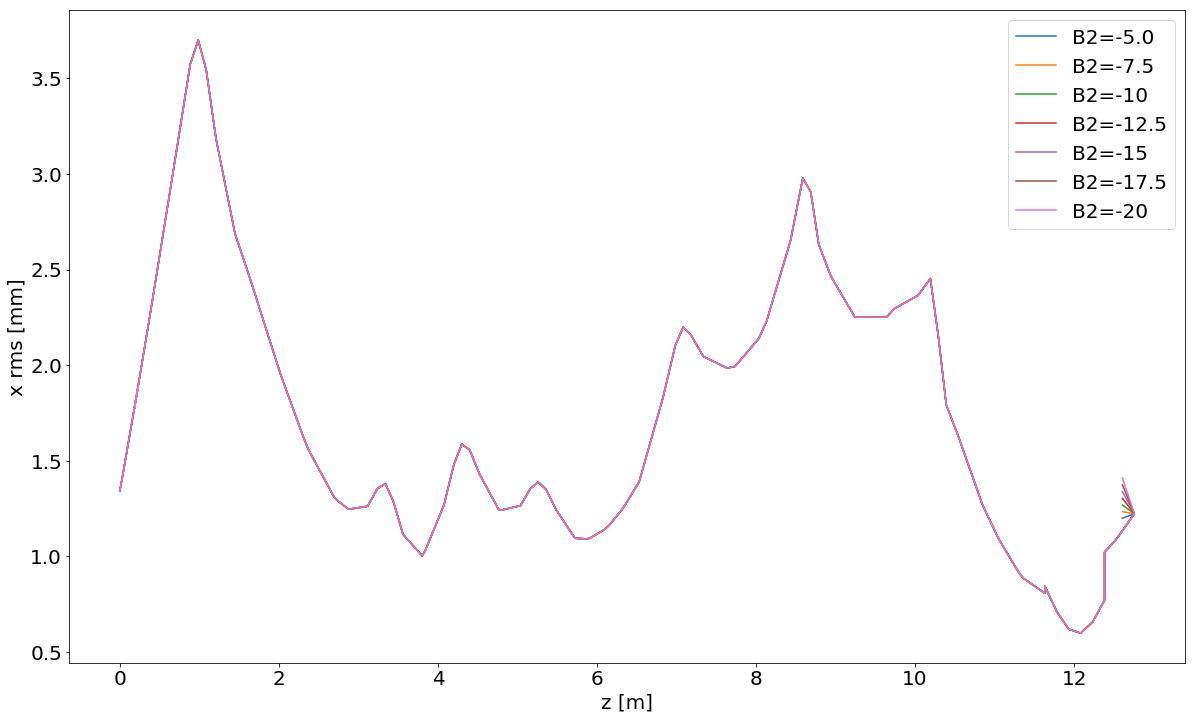

In [18]:
# plot the scan result
zA = [s[1].pos for s in rA]
xA = [s[1].moment0_rms[0] for s in rA] # get the x rms size

for b2,rt in zip(b2lst,rlst):
    zt = zA + [s[1].pos for s in rt] # join the history result
    xt = xA + [s[1].moment0_rms[0] for s in rt]
    plt.plot(zt, xt, label='B2='+str(b2))

plt.ylabel('x rms [mm]')
plt.xlabel('z [m]')
plt.legend(loc='best')
plt.show()